In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [7]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [8]:
dataset_path = r"E:\1. Desktop Files\All AI ML Projects\CFD_CNN Project\archive\Velocity_Flow_Regime"

dataset= datasets.ImageFolder(dataset_path)
len(dataset)

748

In [9]:
dataset.classes

['high_speed_aerofoil',
 'high_speed_elliptic',
 'low_speed_aerofoil',
 'low_speed_elliptic']

In [10]:
num_classes = len(dataset.classes)
num_classes

4

In [11]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [12]:
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

748

In [13]:
dataset.classes

['high_speed_aerofoil',
 'high_speed_elliptic',
 'low_speed_aerofoil',
 'low_speed_elliptic']

In [14]:
num_classes = len(dataset.classes)
num_classes

4

In [15]:
class_names = dataset.classes
class_names

['high_speed_aerofoil',
 'high_speed_elliptic',
 'low_speed_aerofoil',
 'low_speed_elliptic']

### train-test split

In [16]:
train_size=int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(561, 187)

In [17]:
# Now lets do random split for train and validation dataset
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [18]:
# Now lets convert it into dataloaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=True)

In [19]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [20]:
# Lets do some image visualization
images[0].shape

torch.Size([3, 224, 224])

In [21]:
labels[0]

tensor(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4308496].


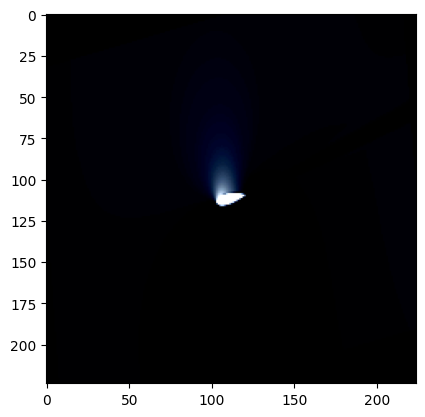

In [24]:
# So "3" means "R_Breakage"
plt.imshow(images[0].permute(1,2,0))
# We got this error because "imshow" expects channel at last and pixels first like this- [224,224,3]

### Model 1: CNN

In [25]:
class VelocityFlowRegimnCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),    # (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (16,112,112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (32, 56,56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (64, 28,28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512,num_classes)   # Right now we have 6 output classes but instead of hardcoding it to 6 if anything changes in future lets call it num_classes
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [26]:
# Initiate the model, loss function and optimizer
model = VelocityFlowRegimnCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [27]:
def train_model(model, criterion, optimizer, epochs=5):
    start=time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for batch_num, (images, labels) in enumerate (train_loader):
            images, labels = images.to(device), labels.to(device)

            #Zero the parameter gradients
            optimizer.zero_grad()
            
            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            #Backward pass
            loss.backward()
            
            #Weight updates
            optimizer.step()

            if (batch_num +1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss +=loss.item()*images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss:{epoch_loss:.4f}")

        # Validation
        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total +=labels.size(0)
                correct+=(predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}%***")
    end=time.time()
    print(f"Execution time: {end-start} seconda")
    
    return all_labels, all_predictions

In [28]:
# For example to see torch.max example
# We can see the 15 is the maximum value and it is having an index of 2
values, index = torch.max(torch.tensor([[10,12,15,9,2]]),1)
values, index

(tensor([15]), tensor([2]))

In [29]:
# lets run our first training loop
# We want to see that whether it is redicing the loss or not, because sometimes if model parameters are not configured properly our loss will not reduce
# So in that case there is no point of running it for all 10 epochs
train_model(model, criterion, optimizer, epochs=1)

Batch: 10, Epoch: 1, Loss: 0.87
Epoch [1/1], Avg Loss:1.0271
*** Validation Accuracy: 88.77%***
Execution time: 130.48401618003845 seconda


([np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(2),
  np.int64(3),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64

In [30]:
# Here we can see that loss is reducing so our model is working fine and we can run it for more epochs
# The accuracy is not very goodwhichh iss 41.9% , but that's ok we can run it for more epochs and accuracy will increase
# Also it printed all the labels and all the predictions in the end,hence that thing is also working ok
# And the execution time for one epoch was around 4 mins
# Now lets run it for more epochs

In [31]:
all_labels,all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.21
Epoch [1/5], Avg Loss:0.2775
*** Validation Accuracy: 89.84%***
Batch: 10, Epoch: 2, Loss: 0.21
Epoch [2/5], Avg Loss:0.2368
*** Validation Accuracy: 91.98%***
Batch: 10, Epoch: 3, Loss: 0.18
Epoch [3/5], Avg Loss:0.2524
*** Validation Accuracy: 89.84%***
Batch: 10, Epoch: 4, Loss: 0.16
Epoch [4/5], Avg Loss:0.2009
*** Validation Accuracy: 90.91%***
Batch: 10, Epoch: 5, Loss: 0.07
Epoch [5/5], Avg Loss:0.2214
*** Validation Accuracy: 92.51%***
Execution time: 1165.9537889957428 seconda


### Model 2: CNN with Regularization

In [34]:
# Add dropout layer by 0.5 layers, batch normalization
class VelocityFlowRegimnCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),    # (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (16,112,112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (32, 56,56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (64, 28,28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)   # Right now we have 6 output classes but instead of hardcoding it to 6 if anything changes in future lets call it num_classes
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [35]:
# Lets add weight decay of 0.0001 which is L2 regularization

model = VelocityFlowRegimnCNNWithRegularization(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001, weight_decay=1e-4)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 4.67
Epoch [1/10], Avg Loss:7.0583
*** Validation Accuracy: 80.75%***
Batch: 10, Epoch: 2, Loss: 3.31
Epoch [2/10], Avg Loss:2.7408
*** Validation Accuracy: 87.70%***
Batch: 10, Epoch: 3, Loss: 0.61
Epoch [3/10], Avg Loss:1.0696
*** Validation Accuracy: 94.12%***
Batch: 10, Epoch: 4, Loss: 0.96
Epoch [4/10], Avg Loss:0.6869
*** Validation Accuracy: 87.70%***
Batch: 10, Epoch: 5, Loss: 0.15
Epoch [5/10], Avg Loss:0.3674
*** Validation Accuracy: 90.91%***
Batch: 10, Epoch: 6, Loss: 0.24
Epoch [6/10], Avg Loss:0.3052
*** Validation Accuracy: 91.44%***
Batch: 10, Epoch: 7, Loss: 0.28
Epoch [7/10], Avg Loss:0.2658
*** Validation Accuracy: 93.05%***
Batch: 10, Epoch: 8, Loss: 0.15
Epoch [8/10], Avg Loss:0.2471
*** Validation Accuracy: 93.05%***
Batch: 10, Epoch: 9, Loss: 0.24
Epoch [9/10], Avg Loss:0.2216
*** Validation Accuracy: 93.58%***
Batch: 10, Epoch: 10, Loss: 0.23
Epoch [10/10], Avg Loss:0.2012
*** Validation Accuracy: 93.05%***
Execution time: 2101.8575892

In [36]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.80      0.77      0.78        26
           2       0.97      1.00      0.98        63
           3       0.82      0.84      0.83        32

    accuracy                           0.93       187
   macro avg       0.90      0.90      0.90       187
weighted avg       0.93      0.93      0.93       187



In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

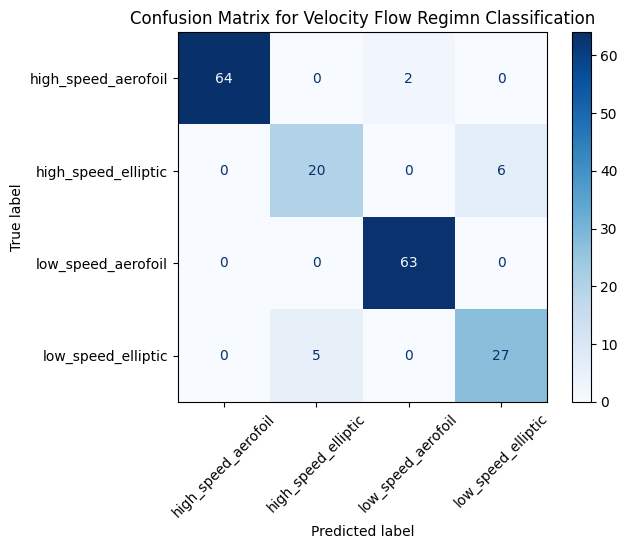

In [38]:
conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Velocity Flow Regimn Classification")
plt.show()

In [39]:
torch.save(model.state_dict(), "saved_model.pth")